# DDPM Benchmark on CIFAR-10 #

In [2]:
# Run this every time on Colab
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/Colab Notebooks/Efficient_Diffusion/noise-efficient-diffusion-model

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Efficient_Diffusion/noise-efficient-diffusion-model


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

print(f"Training data size: {len(trainset)}")
print(f"Test data size: {len(testset)}")


Files already downloaded and verified
Training data size: 50000
Test data size: 10000


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

class DiffusionModel(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, out_channels=3):
        super(DiffusionModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(hidden_channels * 2, hidden_channels * 4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(hidden_channels * 4, hidden_channels * 2, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(hidden_channels * 2, hidden_channels, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.conv6(x)
        return x


def forward_diffusion(x, timesteps, beta_start=1e-4, beta_end=0.02):
    """
    Performs the forward diffusion process.

    Args:
        x: The input image tensor.
        timesteps: The number of diffusion steps.
        beta_start: The initial value of beta.
        beta_end: The final value of beta.

    Returns:
        x_t: The noisy image at the specified timestep.
        noise: The added Gaussian noise.
    """
    beta = torch.linspace(beta_start, beta_end, timesteps).to(x.device)
    alphas = 1. - beta
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    t = torch.randint(0, timesteps, (x.shape[0],)).to(x.device)
    sqrt_alphas_cumprod_t = torch.sqrt(alphas_cumprod[t])
    sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1. - alphas_cumprod[t])
    noise = torch.randn_like(x)
    x_t = sqrt_alphas_cumprod_t.view(-1, 1, 1, 1) * x + sqrt_one_minus_alphas_cumprod_t.view(-1, 1, 1, 1) * noise
    return x_t, noise


Training loop defined here. Needs to be tuned and trained on more epochs while saving loss to plot after

In [ ]:
def train(model, optimizer, trainloader, epochs, timesteps):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        loop = tqdm(trainloader)
        for images, _ in loop:
            images = images.to(device)
            x_t, noise = forward_diffusion(images, timesteps)

            predicted_noise = model(x_t)
            loss = F.mse_loss(predicted_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_description(f"Epoch [{epoch}/{epochs}]")
            loop.set_postfix(loss=loss.item())


model = DiffusionModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 10
timesteps = 100
train(model, optimizer, trainloader, epochs, timesteps)

torch.save(model.state_dict(), "diffusion_model.pth")

Epoch [9/10]: 100%|██████████| 1563/1563 [00:52<00:00, 29.95it/s, loss=1]


<ipython-input-18-eab6804a6714>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("diffusion_model.pth", map_location=device))


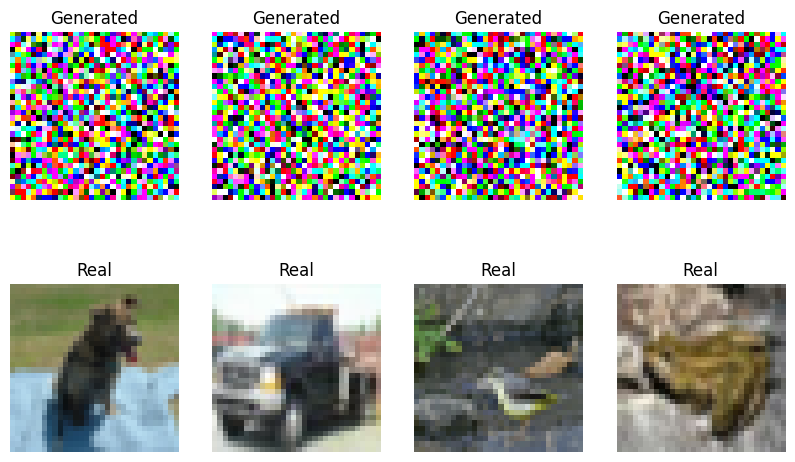

In [ ]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

def generate_samples(model, num_samples, timesteps, device):
    model.eval()
    with torch.no_grad():
        x = torch.randn((num_samples, 3, 32, 32)).to(device)
        for t in range(timesteps - 1, -1, -1):
            predicted_noise = model(x)
            beta = torch.linspace(1e-4, 0.02, timesteps).to(device)[t]
            alpha = 1. - beta
            alpha_cumprod = torch.cumprod(torch.tensor([alpha]).to(device), dim=0)
            if t > 0:
                noise = torch.randn_like(x)
                x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * predicted_noise) + torch.sqrt(beta) * noise
            else:
                x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * predicted_noise)
        generated_samples = x
        return generated_samples

def load_real_images(batch_size=4):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    cifar10 = CIFAR10(root='./data', train=False, download=False, transform=transform)
    real_images_loader = DataLoader(cifar10, batch_size=batch_size, shuffle=True)
    real_images, _ = next(iter(real_images_loader))
    return real_images

model = DiffusionModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("diffusion_model.pth", map_location=device))
model.to(device)

num_samples = 4
timesteps = 100
generated_samples = generate_samples(model, num_samples, timesteps, device)

real_images = load_real_images(batch_size=num_samples)

generated_samples = (generated_samples + 1) / 2
real_images = (real_images + 1) / 2

fig, axes = plt.subplots(2, num_samples, figsize=(10, 6))

for i, ax in enumerate(axes[0]):
    ax.imshow(generated_samples[i].permute(1, 2, 0).cpu().numpy())
    ax.axis("off")
    ax.set_title("Generated")

for i, ax in enumerate(axes[1]):
    ax.imshow(real_images[i].permute(1, 2, 0).cpu().numpy())
    ax.axis("off")
    ax.set_title("Real")

plt.show()

In [ ]:
!pip install pytorch-fid

from pytorch_fid import fid_score
from torchvision import transforms
from torchvision.models import inception_v3
from torch.nn.functional import adaptive_avg_pool2d

def calculate_fid(real_images, generated_images, device, batch_size=32):
    fid = fid_score.calculate_fid_given_paths(
        [real_images, generated_images],
        batch_size,
        device=device,
        dims=2048
    )
    return fid


def calculate_inception_distance(real_images, generated_images, device):
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    def get_inception_activations(images):
        images = adaptive_avg_pool2d(images, (299, 299))  # Resize to 299x299 for Inception
        with torch.no_grad():
            features = inception_model(images)[0]  # Get activations from the last layer
        return features

    real_activations = get_inception_activations(real_images)
    generated_activations = get_inception_activations(generated_images)

    inception_distance = torch.dist(real_activations, generated_activations)
    return inception_distance


num_samples = 100
timesteps = 100
generated_samples = generate_samples(model, num_samples, timesteps, device)
real_images = load_real_images(batch_size=num_samples)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

!mkdir real_images
!mkdir generated_images

# Save the generated images from the tensor to disk
for i, image in enumerate(generated_samples):
    torchvision.utils.save_image(image, f"generated_images/image_{i}.png")

# Assuming `testloader` is available for loading real images
for i, (images, _) in enumerate(testloader):
    # Save only a small batch
    if i < 2:
        for j, image in enumerate(images):
            torchvision.utils.save_image(image, f"real_images/image_{i}_{j}.png")
    else:
        break

fid_value = calculate_fid("real_images", "generated_images", device)
inception_distance_value = calculate_inception_distance(real_images, generated_samples, device)

print("FID:", fid_value)
print("Inception Distance:", inception_distance_value)

# Clean up temporary folders
!rm -rf real_images
!rm -rf generated_images


mkdir: cannot create directory ‘real_images’: File exists
mkdir: cannot create directory ‘generated_images’: File exists


100%|██████████| 4/4 [00:42<00:00, 10.62s/it]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 153MB/s]


FID: 495.09478841984406
Inception Distance: tensor(55.3545)


In [33]:
!echo "$(<.gitignore )"


.gitignore
data/*
initial.ipynb


In [30]:
!git commit -m "Added i"

On branch main
Your branch is ahead of 'origin/main' by 2 commits.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .gitignore
	modified:   diffusion.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
